# Multi-class classification
reference: https://www.learnpytorch.io/03_pytorch_computer_vision/

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
from tqdm.auto import tqdm

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
image, label = training_data[0]
label
image.shape

torch.Size([1, 28, 28])

In [5]:
# Check how many train and test dataset
len(training_data.data), len(training_data.targets), len(test_data.data)

(60000, 60000, 10000)

In [6]:
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

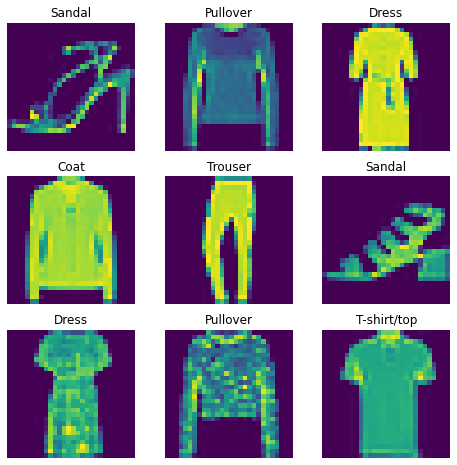

In [7]:
fig = plt.figure(figsize=(8, 8))
rows, columns = 3, 3
for i in range(1,10):
    idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.title(training_data.classes[label])
    plt.axis(False)

## Create DataLoader

In [8]:
from torch.utils.data import DataLoader
# batch_size hyperparameter
batch_size = 32
train_dataloader = DataLoader(training_data, 
                              batch_size=batch_size, 
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=False)

## Build a convolutional neural network

In [9]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units * 7 * 7,
                      out_features= 100),
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x
    

In [10]:
len(training_data.classes)

10

In [11]:
torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1, 
                          hidden_units=10, 
                          output_shape=len(training_data.classes))

In [12]:
model

FashionMNISTModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=100, bias=True)
  )
)

## Setup loss and optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1)

## Traing and testing loop

In [14]:
def train_step(model, dataloader, loss_fn, optimizer, accuracy_fn):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # calculate loss and accuracy per epoch
    size = len(dataloader)
    train_loss /= size
    train_acc /= size
    print(f"Train Error: \n Accuracy: {(train_acc):>0.1f}, Avg loss: {train_loss:>8f} \n")

In [15]:
def test_step(model, dataloader, loss_fn, accuracy_fn):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    size = len(dataloader)
    test_loss /= size
    test_acc /= size
    print(f"Test Error: \n Accuracy: {(test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [17]:
torch.manual_seed(42)

epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}\n-------------------------------")
    train_step(model, train_dataloader, 
               loss_fn, optimizer, accuracy_fn)
    test_step(model, test_dataloader,
              loss_fn, optimizer, accuracy_fn)

Epoch 0
-------------------------------
Train Error: 
 Accuracy: 76.4, Avg loss: 0.670234 

Test Error: 
 Accuracy: 85.8%, Avg loss: 0.399697 

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 86.5, Avg loss: 0.370746 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.372166 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 88.1, Avg loss: 0.329628 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.328002 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 88.9, Avg loss: 0.306222 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.323443 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 89.5, Avg loss: 0.292937 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.315327 



## prediction

In [38]:
def make_predictions(model, data: list):
    
    model.eval()
    images, predictions, pred_probs = [], [], []
    with torch.no_grad():
        for sample in data:
            X = torch.unsqueeze(sample,dim = 0)
            y_pred = model(X)
            # get prediction probabilities
            pred_prob = torch.softmax(y_pred.squeeze(), dim=0)
            images.append(X)
            predictions.append(y_pred.argmax(dim=1))
            pred_probs.append(pred_prob)
    return images, predictions, pred_probs

In [39]:
import random
sample_X, sample_y = zip(*random.sample(list(test_data), k=9))

In [41]:
images, predictions, pred_probs = make_predictions(model, sample_X)

In [42]:
predictions

[tensor([8]),
 tensor([6]),
 tensor([0]),
 tensor([0]),
 tensor([9]),
 tensor([5]),
 tensor([9]),
 tensor([8]),
 tensor([9])]

In [43]:
sample_y

(8, 6, 6, 0, 9, 5, 9, 8, 9)

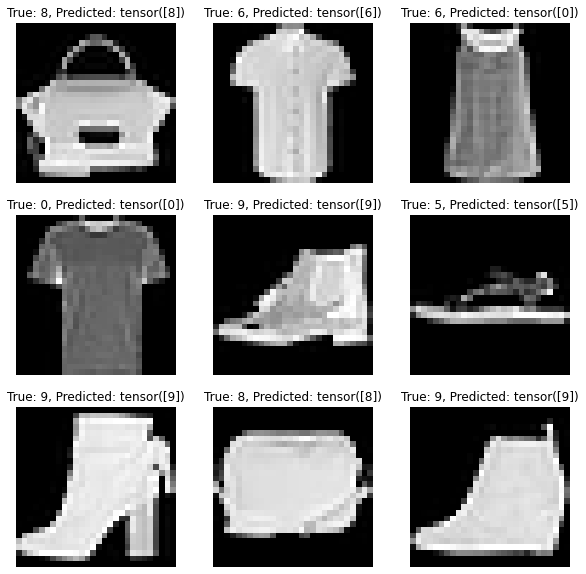

In [45]:
plt.figure(figsize=(10, 10))
nrows, ncols = 3, 3
for i in range(1, 10):
    plt.subplot(nrows, ncols, i)
    plt.imshow(images[i-1].squeeze(), cmap='gray')
    plt.title(f"True: {sample_y[i-1]}, Predicted: {predictions[i-1]}")
    plt.axis(False)

In [46]:
test_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']